In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
def Heatsquare(deg,N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
    geos=[
        geometry.unit_square().scale(2).translate((-1,-1))
    ]
    patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    M.h_refine(patches=None)
    M.set_domain_id({1:{1}})
    return M

In [4]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_indicator=[]
    refined=[]
    P = []
    #params['u_sol']=u_sol
    # params['ux']=ux
    # params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig, knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator.append(adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True))
            err_est[iter] = norm(err_indicator[-1])
            marked_patches = adap.doerfler_marking(err_indicator[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P_i = MP.patch_refine(h_ref=marked_patches, return_P = True)
            for i in range(len(P)):
                P[i]=P_i@P[i]
            P.append(P_i)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_indicator, refined, P

In [5]:
deg=2
M = Heatsquare(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=5
uh=[]
numdofs = np.zeros(maxiter,dtype=float)
P=[]
return_P = True

for i in range(maxiter):
    print(i)
    bcs = MP.compute_dirichlet_bcs({0:0.})
    Ah = MP.assemble_volume(vform.stiffness_vf(2,a=1),domain_id=0) + MP.assemble_volume(vform.stiffness_vf(2,a=1e6),domain_id=1)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    uh.append(LS.complete((cholesky(LS.A))(LS.b)))
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    
    if i < maxiter-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter)
H1err = np.zeros(maxiter)
Aherr = np.zeros(maxiter)
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

np.savetxt('Jp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Basis setup took 0.013847827911376953 seconds
0


/tmp/ipykernel_7197/3259017959.py:18: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh.append(LS.complete((cholesky(LS.A))(LS.b)))


289
Refinement took 0.0005526542663574219 seconds
Basis setup took 0.006531476974487305 seconds
Prolongation took 0.00794839859008789 seconds
1
729
Refinement took 0.00017380714416503906 seconds
Basis setup took 0.011568307876586914 seconds
Prolongation took 0.008844137191772461 seconds
2
2209
Refinement took 0.0004208087921142578 seconds
Basis setup took 0.02913069725036621 seconds
Prolongation took 0.011439085006713867 seconds
3
7569
Basis setup took 0.10838818550109863 seconds
Prolongation took 0.02225637435913086 seconds
4
27889


Basis setup took 0.009495735168457031 seconds


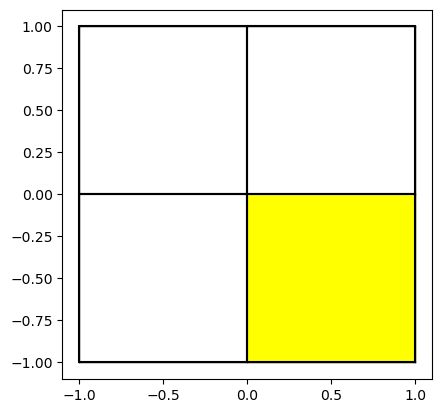

0
Residual contributions took 0.026815176010131836 seconds.
Jump contributions took 0.023113250732421875 seconds.
Refinement took 0.005832672119140625 seconds
Basis setup took 0.010102987289428711 seconds
Prolongation took 0.014562606811523438 seconds


/tmp/ipykernel_6724/761089257.py:24: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))


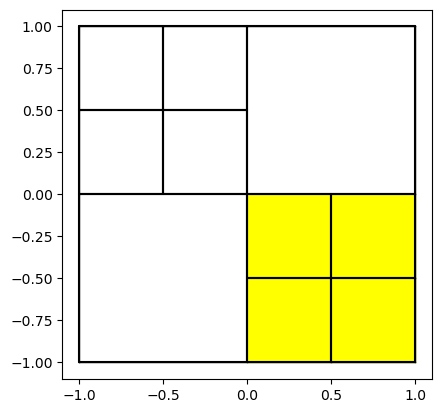

1
Residual contributions took 0.06854867935180664 seconds.
Jump contributions took 0.09043550491333008 seconds.
Refinement took 0.00978851318359375 seconds
Basis setup took 0.017415523529052734 seconds
Prolongation took 0.021497726440429688 seconds


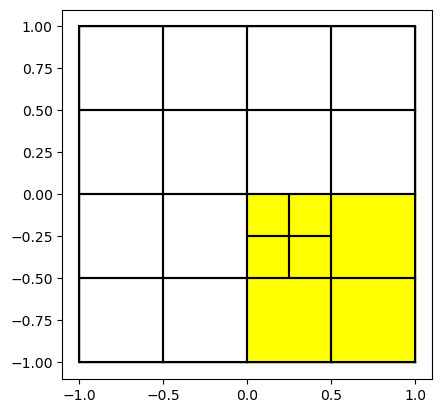

2
Residual contributions took 0.12205958366394043 seconds.
Jump contributions took 0.17754912376403809 seconds.
Refinement took 0.011474847793579102 seconds
Basis setup took 0.024999380111694336 seconds
Prolongation took 0.021548986434936523 seconds


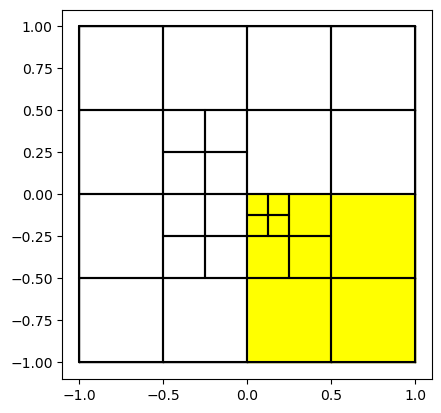

3
Residual contributions took 0.17664766311645508 seconds.
Jump contributions took 0.30202651023864746 seconds.
Refinement took 0.013772964477539062 seconds
Basis setup took 0.03083968162536621 seconds
Prolongation took 0.021224498748779297 seconds


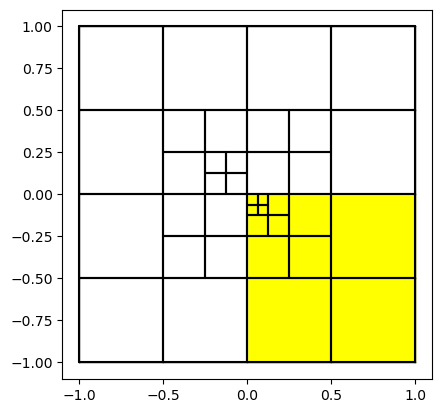

4
Residual contributions took 0.23278427124023438 seconds.
Jump contributions took 0.4196045398712158 seconds.
Refinement took 0.01529693603515625 seconds
Basis setup took 0.04043388366699219 seconds
Prolongation took 0.021968364715576172 seconds


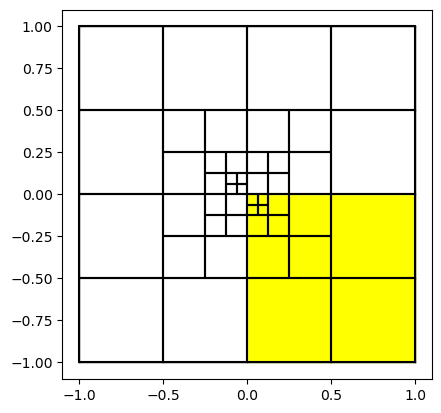

5
Residual contributions took 0.28952598571777344 seconds.
Jump contributions took 0.5321352481842041 seconds.
Refinement took 0.0230710506439209 seconds
Basis setup took 0.046245574951171875 seconds
Prolongation took 0.028139829635620117 seconds


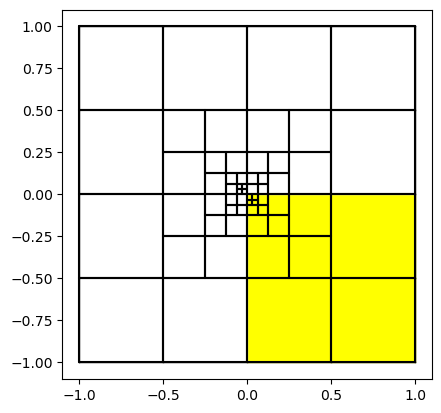

6
Residual contributions took 0.3666558265686035 seconds.
Jump contributions took 0.694976806640625 seconds.
Refinement took 0.03336834907531738 seconds
Basis setup took 0.060628414154052734 seconds
Prolongation took 0.0345911979675293 seconds


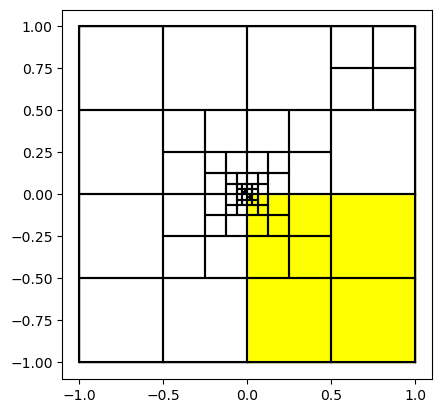

7
Residual contributions took 0.4557003974914551 seconds.
Jump contributions took 0.8724205493927002 seconds.
Refinement took 0.06184267997741699 seconds
Basis setup took 0.07300376892089844 seconds
Prolongation took 0.05444645881652832 seconds


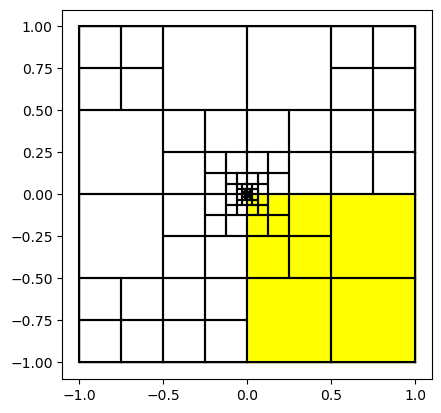

8
Residual contributions took 0.6083836555480957 seconds.
Jump contributions took 1.1506872177124023 seconds.
Refinement took 0.05378866195678711 seconds
Basis setup took 0.08769965171813965 seconds
Prolongation took 0.0475771427154541 seconds


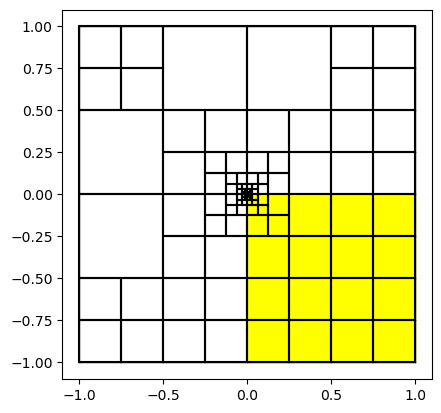

9
Residual contributions took 0.759803295135498 seconds.
Jump contributions took 1.3595104217529297 seconds.
Refinement took 0.039637088775634766 seconds
Basis setup took 0.08678555488586426 seconds
Prolongation took 0.028348684310913086 seconds


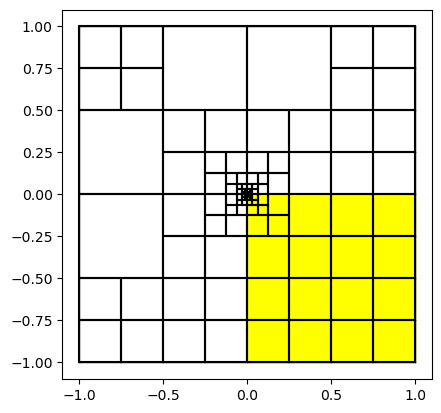

10
Residual contributions took 0.7849557399749756 seconds.
Jump contributions took 1.4869701862335205 seconds.
Refinement took 0.08776736259460449 seconds
Basis setup took 0.11125540733337402 seconds
Prolongation took 0.05538225173950195 seconds


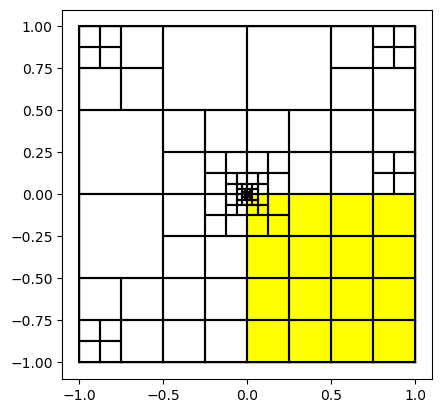

11
Residual contributions took 0.9481580257415771 seconds.
Jump contributions took 1.814833164215088 seconds.
Refinement took 0.08772659301757812 seconds
Basis setup took 0.12481093406677246 seconds
Prolongation took 0.04848980903625488 seconds


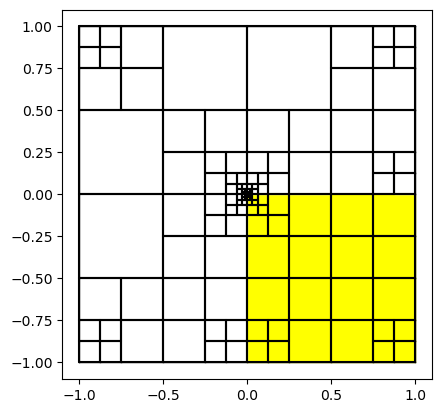

12
Residual contributions took 1.063044548034668 seconds.
Jump contributions took 2.038389205932617 seconds.
Refinement took 0.06920337677001953 seconds
Basis setup took 0.14385199546813965 seconds
Prolongation took 0.03551959991455078 seconds


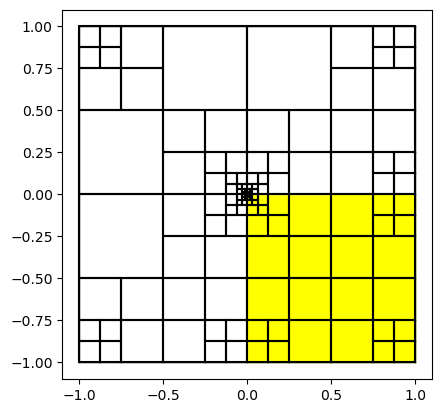

13
Residual contributions took 1.1513524055480957 seconds.
Jump contributions took 2.2304012775421143 seconds.
Refinement took 0.1658618450164795 seconds
Basis setup took 0.16191411018371582 seconds
Prolongation took 0.07645082473754883 seconds


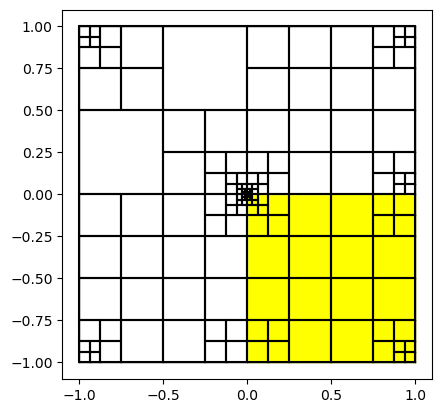

14
Residual contributions took 1.3855781555175781 seconds.
Jump contributions took 2.7469642162323 seconds.
Refinement took 0.15584921836853027 seconds
Basis setup took 0.18252992630004883 seconds
Prolongation took 0.06484365463256836 seconds


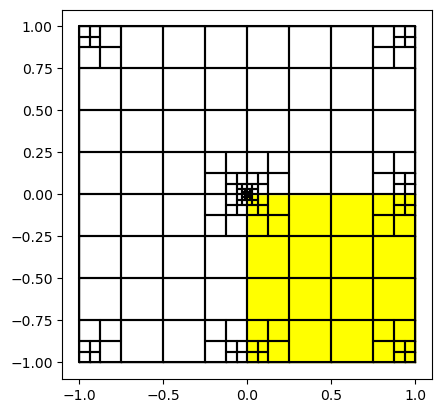

15
Residual contributions took 1.5556464195251465 seconds.
Jump contributions took 2.9615371227264404 seconds.
Refinement took 0.4674227237701416 seconds
Basis setup took 0.24068737030029297 seconds
Prolongation took 0.16225433349609375 seconds


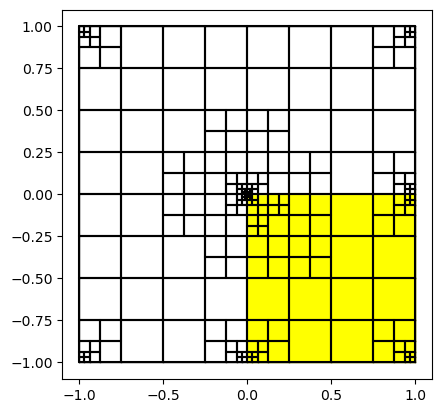

16
Residual contributions took 1.9701297283172607 seconds.
Jump contributions took 3.777601718902588 seconds.
Refinement took 0.7703757286071777 seconds
Basis setup took 0.30864644050598145 seconds
Prolongation took 0.22304224967956543 seconds


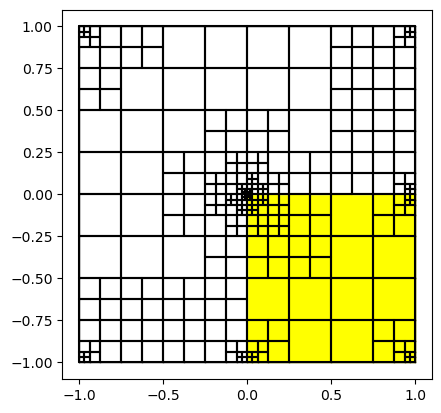

17
Residual contributions took 2.5627760887145996 seconds.
Jump contributions took 4.795538425445557 seconds.
Refinement took 0.9252815246582031 seconds
Basis setup took 0.41939640045166016 seconds
Prolongation took 0.22700119018554688 seconds


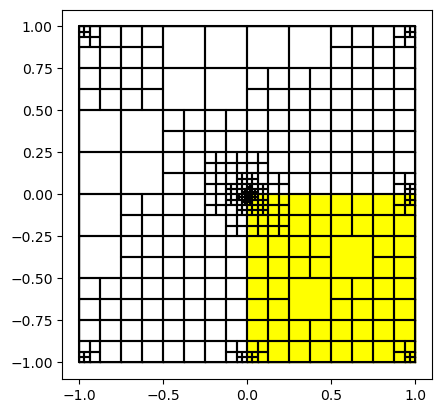

18
Basis setup took 0.8460264205932617 seconds
Prolongation took 0.9322643280029297 seconds


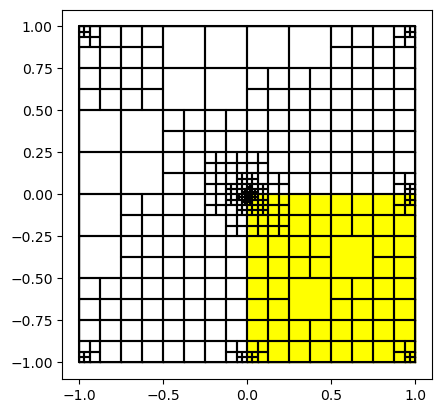

19


In [8]:
deg=3
M_a = Heatsquare(deg,deg+1)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]

maxiter=20
numdofs_a =np.zeros(maxiter)
err_est=np.zeros(maxiter)
gamma=1e4

for i in range(maxiter):
    MP_a.mesh.draw(color={0:'white',1:'yellow'})
    plt.show()
    print(i)
    bcs = MP_a.compute_dirichlet_bcs({0:0.})
    Ah_a = MP_a.assemble_volume(vform.stiffness_vf(2,a=1.),domain_id=0) + MP_a.assemble_volume(vform.stiffness_vf(2,a=gamma),domain_id=1)
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
    F = MP_a.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    #print(Ah.shape)
    LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
    uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))
    numdofs_a[i] = MP_a.numdofs
    #print(MP_a.numdofs)
    
    if i < maxiter-2 :
        err_ind.append(adap.PoissonEstimator(MP_a,uh_a[i],a={0:1.,1:gamma}, f={0:lambda x,y: 1.,1:lambda x,y: 1.}))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        #MP_a.mesh.draw(plt.figure())
    elif i == maxiter-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter)
H1err_a = np.zeros(maxiter)
Aherr_a = np.zeros(maxiter)
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    Aherr_a[i] = eh @ Ah_a @ eh
    
L2err_a = sqrt(L2err_a)
H1err_a = sqrt(H1err_a)
Aherr_a = sqrt(Aherr_a)

np.savetxt('Jp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

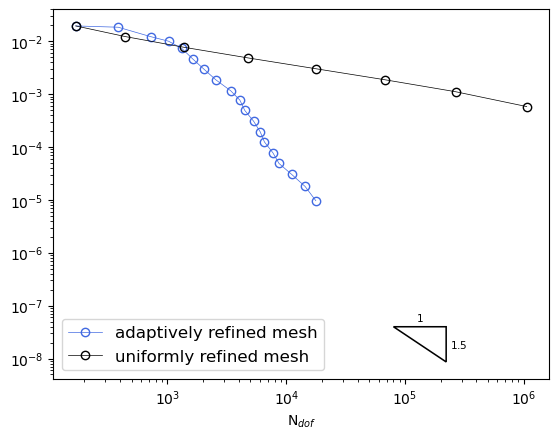

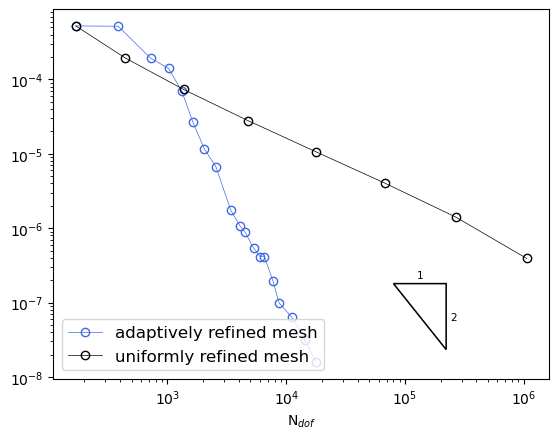

In [9]:
deg=3
[numdofs,H1err,L2err,err_est]=np.loadtxt('Jp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Jp'+str(deg)+'n'+str(deg+1)+'.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-2], err_est[:-2], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(8*1e4,0.4*1e-7),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(1e4,0.55*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(8*1e4,1.8*1e-7),2,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(1e4,3*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

In [9]:
L2err_a

array([2.44189e-05, 2.42044e-05, 9.21431e-06, 7.85660e-06, 3.49643e-06, 2.10482e-06, 1.30443e-06, 6.47659e-07, 4.10593e-07, 3.04913e-07, 2.36671e-07, 2.12374e-07, 1.91608e-07, 1.86851e-07, 1.73713e-07, 1.59112e-07, 1.59729e-07, 1.56883e-07, 9.96519e-08, 9.78859e-08, 2.65061e-08, 0.00000e+00])

In [136]:
numdofs_a

array([1.69000e+02, 4.84000e+02, 1.60000e+03, 5.77600e+03, 2.19040e+04, 8.52640e+04, 3.36400e+05, 1.33634e+06])

In [133]:
np.log(H1err[:-2]/H1err[1:-1])/np.log(sqrt(numdofs[:-2]/numdofs[1:-1]))

array([-0.98396, -0.84132, -0.78312, -0.80184, -0.98881])

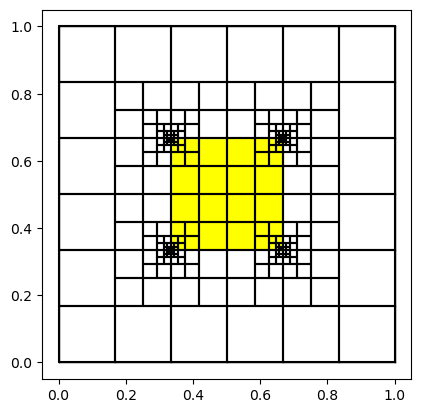

In [118]:
MP_a.mesh.draw(color={0:'white',1:'yellow'})

In [120]:
L2err

array([1.05325e-05, 3.90575e-06, 1.40087e-06, 4.72760e-07, 1.60715e-07, 1.46990e-07, 0.00000e+00])

In [122]:
H1err_a

array([0.00456, 0.00277, 0.00172, 0.00108, 0.00067, 0.0004 , 0.00022, 0.     ])

In [75]:
def spy(A, marker=None, markersize=10, cbar=False, cmap = plt.cm.jet, **kwargs):
    fig = plt.figure(figsize=kwargs.get('figsize'))
    ax = plt.axes()
    
    A = A.tocoo()
    data, I, J = A.data, A.row, A.col
    if cbar:
        plt.scatter(J, I, c=data, marker="s", s=100, cmap = cmap)
    else:
        plt.scatter(J, I, s=100, marker="s")
    ax.axis('scaled');
    ax.set_xlim(-0.5,A.shape[1]-0.5)
    ax.set_ylim(-0.5,A.shape[0]-0.5)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    if cbar:
        cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(cax=cax) # Similar to fig.colorbar(im, cax = cax)
    

In [76]:
M=scipy.sparse.rand(100,100,density=0.01)

In [77]:
M.shape

(100, 100)

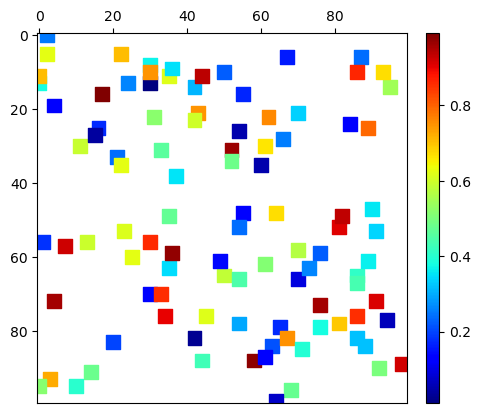

In [78]:
spy(M,cbar=1,markersize=10)

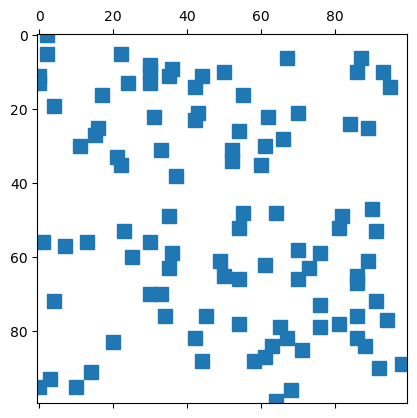

In [79]:
plt.spy(M)

In [90]:
M=scipy.sparse.rand(10,10,density=0.1)
data, I ,J = M.data, M.row, M.col

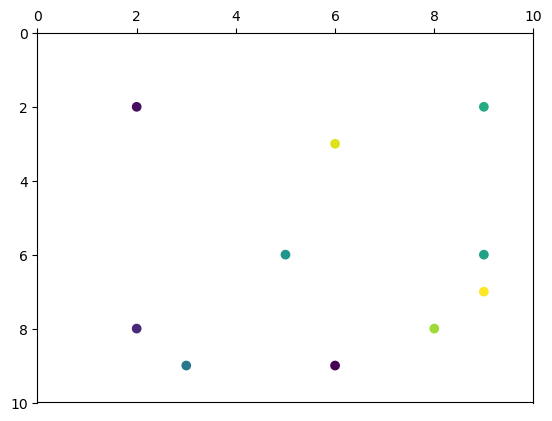

In [93]:
fig = plt.figure()
ax = plt.axes()
plt.scatter(I,J,c=data)
ax.set_xlim(0,M.shape[1])
ax.set_ylim(0,M.shape[0])
ax.invert_yaxis()
ax.xaxis.tick_top()


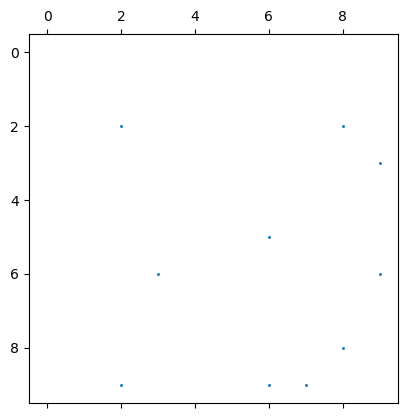

In [92]:
fig=spy(M,markersize=1)